## Long short-term memory

*Эпоха* - это **весь** датасет обученный один раз: forwarding и back propagation. Количество эпох зависит от данных, т.е. нельзя в точности сказать что для такой-то задачи нужно вот столько-то эпох. Слишком много эпох вызовет переобучение, слишком мало может вызвать недообучение.

*Батч* - это часть датасета, т.е. весь датасет можно разбить на батчи какого-то размера. Количество батчей равняется количеству итераций в эпохе, и если посмотреть с другой стороны, то количество итерации - это количество батчей для обучения одной эпохи.

In [81]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from metrics import mar, far, f1_score

In [82]:
from keras.models import Sequential
from keras.layers import TimeDistributed, Dense, LSTM, RepeatVector

### Process data

In [83]:
df = pd.read_csv("./data/anomaly-free/anomaly-free.csv", 
                 sep=";", parse_dates=True, index_col="datetime")

df.sort_index(inplace=True)
df.head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2020-02-08 13:30:47,0.202394,0.275154,2.16975,0.382638,90.6454,26.8508,238.852,122.664
2020-02-08 13:30:48,0.203153,0.277857,2.07999,-0.273216,90.7978,26.8639,227.943,122.338
2020-02-08 13:30:50,0.202054,0.275790,2.52577,0.382638,90.7730,26.8603,223.486,121.338
2020-02-08 13:30:51,0.203595,0.278101,2.49742,0.054711,90.8424,26.8616,244.904,121.664
2020-02-08 13:30:52,0.201889,0.276363,2.29194,0.710565,90.6664,26.8603,239.196,122.000


In [84]:
SS = StandardScaler()
x_train = np.array(SS.fit_transform(df))

In [85]:
TIME_STEPS = 20

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

x_train = create_sequences(x_train)
print("Training input shape: ", x_train.shape)

Training input shape:  (9386, 20, 8)


### Make model

In [86]:
n_features = x_train.shape[2]

In [87]:
model = Sequential()

model.add(LSTM(units=128, activation='relu', return_sequences=True, 
               input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(LSTM(units=64, activation='relu', return_sequences=False))
# Encoding is done
model.add(RepeatVector(TIME_STEPS))

model.add(LSTM(units=64, activation='relu', return_sequences=True))
model.add(LSTM(units=128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))

model.compile(optimizer='adam', loss='mse')

### Fitting

In [88]:
import keras

In [89]:
history = model.fit(x_train, x_train, epochs=1, batch_size=5)

1878/1878 [==============================] - 128s 65ms/step - loss: 0.5306


In [91]:
Q = 0.99

In [92]:
health_r = pd.Series(np.sum(np.mean(np.abs(model.predict(x_train) - x_train), axis=1), axis=1))
UCL = health_r.quantile(Q)

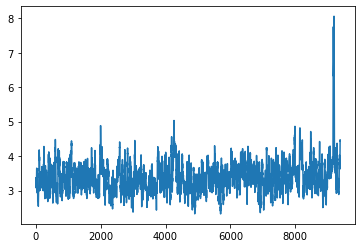

In [93]:
plt.plot(health_r)

### Make predictions

In [94]:
df = pd.read_csv("./data/valve1/6.csv", sep=";", parse_dates=True, index_col="datetime")
df = df.sort_index()

y_test = np.array(df["anomaly"].astype(int))
df.drop(["anomaly", "changepoint"], inplace=True, axis=1)

x_test = np.array(SS.transform(df))

In [95]:
x_test = create_sequences(x_test)
print("Training input shape: ", x_test.shape)

Training input shape:  (1135, 20, 8)


In [96]:
r = pd.Series(np.sum(np.mean(np.abs(model.predict(x_test) - x_test), axis=1), axis=1))

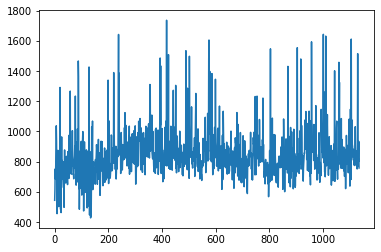

In [97]:
plt.plot(r)

In [100]:
anomalous_data = r > (3/2 * UCL)
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(x_test) - TIME_STEPS + 1):
    if np.all(anomalous_data[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [101]:
prediction = pd.Series(data=0, index=df.index)
prediction.iloc[anomalous_data_indices] = 1

### Vizualization

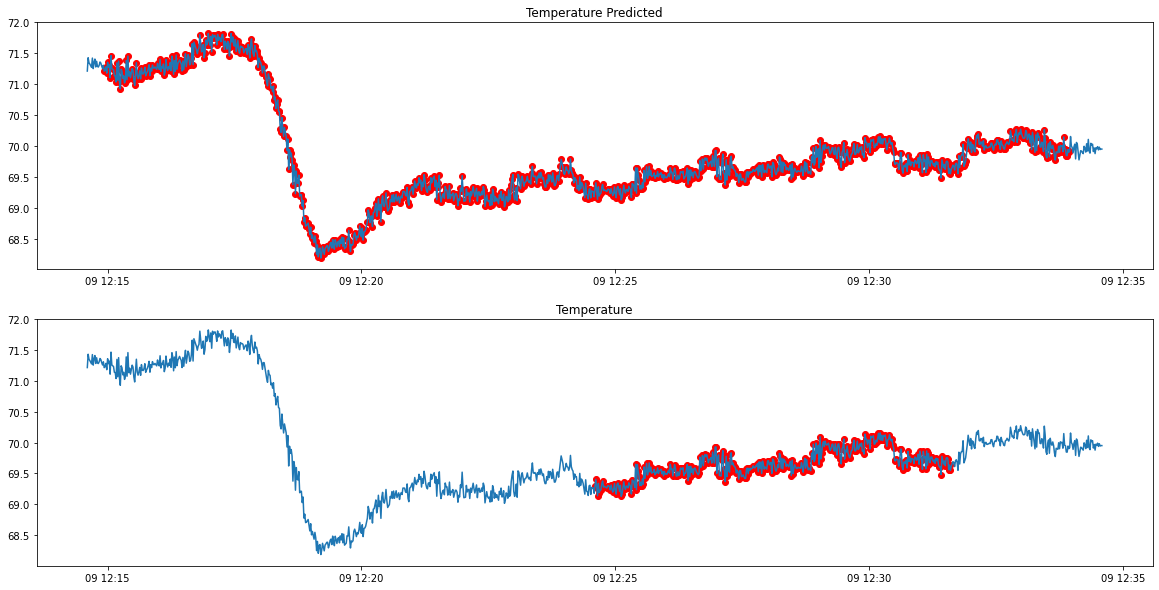

In [108]:
fig, axs = plt.subplots(2, 1, figsize=(20,10))
temperatures = df.Temperature
axs[0].plot(temperatures)
axs[1].plot(temperatures)

y = pd.Series(prediction)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, temperatures[anomalies_indecies], color='r')
axs[0].set_title("Temperature Predicted")

y = pd.Series(y_test)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], temperatures[anomalies_indecies], color='r')
axs[1].set_title("Temperature")

plt.show()

In [109]:
print(f"""F1 = {f1_score(y_test, prediction)}
FAR = {far(y_test, prediction)}
MAR = {mar(y_test, prediction)}""")

F1 = 0.5392809587217043
FAR = 0.9238985313751669
MAR = 0.0
